In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

In [2]:
from utils import *
from data import *
from layers import *
from models import *

In [3]:
import pickle as p
import io 

In [4]:
limit_gpus()
set_gpu(3)

In [5]:
dataset = "mnist"
n_batch = 256

ds_train, ds_test, ds_info = load_dataset(dataset)

input_shape = ds_info.features['image'].shape
num_classes = ds_info.features['label'].num_classes


In [6]:
ds_test = ds_test.batch(n_batch)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [7]:
head = keras.models.load_model("models/ae_conv_head.h5")
head.compile()

inv_head = keras.models.load_model("models/ae_inv_head.h5")
inv_head.compile()

In [8]:
n_d = 1000
n_hidden = 100

image_input = keras.Input(shape=input_shape)
class_input = keras.Input(shape=(n_d,))

In [9]:
dat_x, dat_y = get_raw_dat(ds_train.batch(128))

In [10]:
cdp = class_data_pairs(dat_x,dat_y)

12665
12089
11263
12183
11800


In [11]:
def conf_acc(model):
    conf = model.accuracy(ds_test, True)[0]
    acc = confusion_to_acc(conf)
    print(acc)
    plt.pcolor(conf)

In [12]:
plotconf = lambda: conf_acc(incm)

In [13]:
incm = BridgeModel(head, inv_head, ds_info, n_d=n_d, n_hidden=n_hidden, sigma=3.0, overscan=100)
incm.compile(optimizer="rmsprop")

# train on first dataset

In [14]:
ext1 = incm.generate_external(cdp[0].batch(128), True)

In [15]:
loss = incm.train(ext1,1)

Training loss [0.9836089 0.9948751 1.0009196 1.0026917]


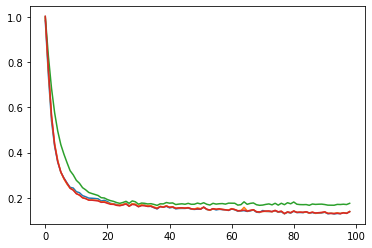

In [16]:
plt.plot(loss)

0.2114


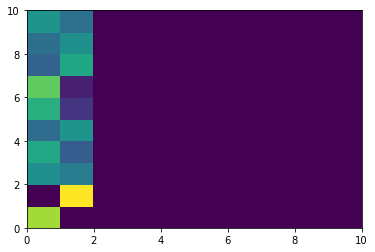

In [17]:
plotconf()

In [19]:
incm.save_weights("models/inc1/step1")

# Train on second set

In [20]:
h1 = ext1[-1]

In [21]:
old1 = incm.generate_internal(h1, truefwd=False)

In [22]:
ext2 = incm.generate_external(cdp[1].batch(128), True)

In [23]:
cf = lambda x: tf.concat(*x, axis=0)

In [24]:
#incm.train(mixed, 2)
loss, dat = incm.train_interleaved(cdp[1], old1, 200, split=[64, 64])

Training loss [0.24785453 0.24541028 0.5471343  0.24613595]
Training loss [0.10230939 0.095395   0.12393179 0.09467018]


0.41


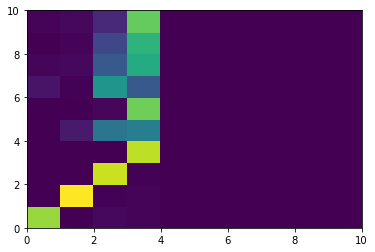

In [25]:
plotconf()

In [26]:
incm.save_weights("models/inc1/step2")

# Train on third set

In [27]:
h2 = ext2[-1]

In [28]:
mixh = tf.random.shuffle(tf.concat((h2, h1), axis=0))

In [29]:
mixh.shape

TensorShape([24754, 1000])

In [30]:
old2 = incm.generate_internal(mixh, truefwd=False)

In [31]:
ext3 = incm.generate_external(cdp[2].batch(128), True)

In [32]:
#incm.load_weights("si_step2")

In [33]:
#incm.train(mixed, 2)
loss, dat = incm.train_interleaved(cdp[2], old2, 200, split=[64, 64])

Training loss [0.24739903 0.2289364  0.5713993  0.22714403]
Training loss [0.10053489 0.09305353 0.11144112 0.09401534]


0.5643


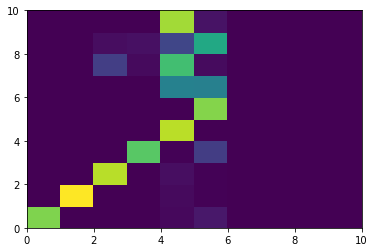

In [34]:
plotconf()

In [35]:
incm.save_weights("models/inc1/step3")

# Train on fourth set

In [36]:
h3 = ext3[-1]

In [37]:
mixh = tf.random.shuffle(tf.concat((h3, h2, h1), axis=0))

In [38]:
mixh.shape

TensorShape([36017, 1000])

In [39]:
old3 = incm.generate_internal(mixh, truefwd=False)

In [40]:
ext4 = incm.generate_external(cdp[3].batch(128), True)

In [41]:
#incm.load_weights("si_step2")

In [42]:
#incm.train(mixed, 2)
loss, dat = incm.train_interleaved(cdp[3], old3, 200, split=[64, 64])

Training loss [0.23201022 0.21125764 0.3782074  0.21055183]
Training loss [0.08693018 0.07974522 0.10014571 0.07971215]


0.7017


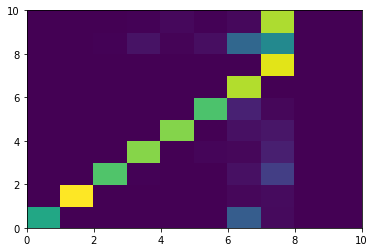

In [43]:
plotconf()

In [44]:
incm.save_weights("models/inc1/step4")

# Train on fifth & last pair

In [45]:
h4 = ext4[-1]

In [46]:
mixh = tf.random.shuffle(tf.concat((h4, h3, h2, h1), axis=0))

In [47]:
mixh.shape

TensorShape([48200, 1000])

In [48]:
old4 = incm.generate_internal(mixh, truefwd=False)

In [50]:
#incm.train(mixed, 2)
loss, dat = incm.train_interleaved(cdp[4], old4, 100, split=[64, 64])

Training loss [0.235434   0.22555338 0.57321835 0.2195861 ]


0.813


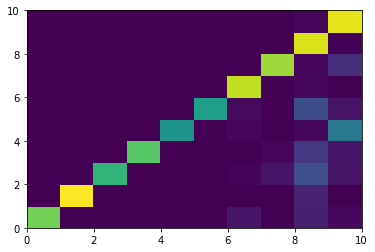

In [51]:
plotconf()

In [70]:
incm.save_weights("models/inc1/step5")